# `Plant Leaf Diseases: Dynamic vizualisation`

This Notebook lets you to scroll through the images of plants with the different conversions

In [1]:
import os
import random as rm

import numpy as np

import cv2 as cv
from plantcv import plantcv as pcv

import ipywidgets as widgets
from IPython.display import display, clear_output

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from PIL import Image, ImageEnhance
from matplotlib import pyplot as plt

from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
import os
import sys
module_path = os.path.abspath('../../utilities')
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import *
from remove_background_functions import *

##### Global variables

In [3]:
augmented = False
slider_range = 10

##### Get the images metatdata

In [4]:
if augmented:
    path_name = '../../data/augmentation'
else:
    path_name = '../../data/no_augmentation'

df_md_images = getDf(path = path_name)

display(df_md_images.head())


,number_img,disease,disease_family,healthy,specie
Strawberry___healthy,456,healthy,healthy,True,strawberry
Grape___Black_rot,1180,black_rot,rot,False,grape
Potato___Early_blight,1000,early_blight,blight,False,potato
Blueberry___healthy,1502,healthy,healthy,True,blueberry
Cherry___Powdery_mildew,1052,powdery_mildew,mildew,False,cherry


##### Set the dropdown dictionary function

In [5]:
def set_dropdown_dict(df):
    d = {}
    for specie in ['All']+sorted(df.specie.unique()):
        d[specie] = {}
        for healthy in ['All']+sorted(df.loc[(df.specie==specie)|(specie=='All')].healthy.unique()):
            d[specie][healthy] = {}
            for disease_family in ['All']+sorted(df.loc[((df.specie==specie)|(specie=='All'))&
                                ((df.healthy==healthy)|(healthy=='All'))].disease_family.unique()):
                d[specie][healthy][disease_family] = list(sorted(df.loc[((df.specie==specie)|(specie=='All'))&
                                                        ((df.healthy==healthy)|(healthy=='All'))&
                                                        ((df.disease_family==disease_family)|(disease_family=='All'))].disease.unique()))
                if len(d[specie][healthy][disease_family])>1:
                    d[specie][healthy][disease_family] = ['All']+d[specie][healthy][disease_family]
    return d

##### Define the plot images function

In [6]:
def plot_images(images, img_dir):
      fig = make_subplots(rows=2, cols=5, subplot_titles = ('Orig','Gray','Canny Edges','Dilated','Eroded','Enhanced','Enhanced Gray','Normalized','Enhanced with Canny','Cropped & Resized'), 
                        shared_yaxes=True, horizontal_spacing=0.01, vertical_spacing=0.1)

      # Define Traces
      fig.add_trace(go.Image(  z=images['rgb_img'][0])       ,                                      row=1, col=1)
      fig.add_trace(go.Heatmap(z=images['gray_img'][0]       , colorscale='gray', showscale=False), row=1, col=2)
      fig.add_trace(go.Heatmap(z=images['canny'][0]          , colorscale='gray', showscale=False), row=1, col=3)
      fig.add_trace(go.Heatmap(z=images['dilated'][0]        , colorscale='gray', showscale=False), row=1, col=4)
      fig.add_trace(go.Heatmap(z=images['eroded'][0]         , colorscale='gray', showscale=False), row=1, col=5)
      fig.add_trace(go.Image(  z=images['enhanced'][0])      ,                                      row=2, col=1)
      fig.add_trace(go.Heatmap(z=images['img_gray_enh'][0]   , colorscale='gray', showscale=False), row=2, col=2)
      fig.add_trace(go.Image(  z=images['normalized_img'][0] ,zmax=[1.,1.,1.,1.]) ,                                      row=2, col=3)
      fig.add_trace(go.Image(  z=images['enh_canny'][0])     ,                                      row=2, col=4)
      fig.add_trace(go.Image(  z=images['crop_res'][0])      ,                                      row=2, col=5)

      # Define frames
      number_frames = len(images['rgb_img'])
      frames = [dict(
                  name=img_dir[k],
                  data=[go.Image(  z=images['rgb_img'][k])       ,                                      
                        go.Heatmap(z=images['gray_img'][k]       , colorscale='gray', showscale=False), 
                        go.Heatmap(z=images['canny'][k]          , colorscale='gray', showscale=False), 
                        go.Heatmap(z=images['dilated'][k]        , colorscale='gray', showscale=False), 
                        go.Heatmap(z=images['eroded'][k]         , colorscale='gray', showscale=False), 
                        go.Image(  z=images['enhanced'][k])      ,                                      
                        go.Heatmap(z=images['img_gray_enh'][k]   , colorscale='gray', showscale=False), 
                        go.Image(  z=images['normalized_img'][k] ,zmax=[1.,1.,1.,1.]) ,                                      
                        go.Image(  z=images['enh_canny'][k])     ,                                      
                        go.Image(  z=images['crop_res'][k])     
                        ],
                  traces=[i for i in range(len(images))] 
                  ) for k in range(number_frames)]


      # Play button
      updatemenus = [dict(type='buttons',
                        buttons=[dict(label='&#9654;',
                                    method='animate',
                                    args=[[img_dir[k] for k in range(number_frames)],
                                          dict(frame=dict(duration=1000, redraw=True),
                                                transition=dict(duration=0),
                                                easing='linear',
                                                fromcurrent=True,
                                                mode='immediate'
                                                )]),
                              dict(label='&#9724;',
                                    method='animate',
                                    args=[[None],
                                          dict(frame=dict(duration=0, redraw=False),
                                                transition=dict(duration=0),
                                                mode='immediate'
                                                )])
                              ],
                        direction='left',
                        pad=dict(r=10, t=70),
                        showactive=True, x=0.1, y=0, xanchor='right', yanchor='top')
                  ]

      # Slider
      sliders = [{'yanchor': 'top',
                  'xanchor': 'left',
                  'currentvalue': {'font': {'size': 12, 'color':'steelblue'}, 'prefix': 'Image Frame: ', 'visible': True, 'xanchor': 'left'},
                  'transition': {'duration': 0, 'easing': 'linear'},
                  'pad': {'b': 10, 't': 60},
                  'len': 0.9, 'x': 0.1, 'y': 0,
                  'font': {'color':'steelblue', 'size':10},
                  'steps': [{'args': [[img_dir[k]], {'frame': {'duration': 0, 'easing': 'linear', 'redraw': True},
                                          'transition': {'duration': 0, 'easing': 'linear'}}],
                        'label': f"<i>{replace_text(img_dir[k],['_','/image ', '.JPG', '  '])}</i>", 'method': 'animate'} for k in range(number_frames)
                        ]}]

      annotations= [{'font': {'color':'steelblue', 'size':15}} for _ in range(len(images))]

      fig.update(frames=frames),
      fig.update_layout(updatemenus=updatemenus, annotations=annotations,
                        sliders=sliders, height=600, width=900)

      fig.show(renderer='notebook')

##### Upload and convert the selected images

In [7]:
def list_of_images(img_dir):
    images = {'rgb_img':[], 'gray_img':[], 'canny':[], 'eroded':[], 'dilated':[], 'enhanced':[], 'img_gray_enh':[], 'normalized_img':[], 'enh_canny':[], 'crop_res':[]}

    for filename in img_dir:
        rgb_img, gray_img, canny, dilated, eroded, enhanced, img_gray_enh, normalized_img, enh_canny, crop_res = preprocess_images(filename)

        images['rgb_img'].append(np.array(rgb_img, dtype='uint8'))
        images['gray_img'].append(np.array(gray_img, dtype='uint8'))
        images['canny'].append(np.invert(np.array(canny, dtype='uint8')))
        images['dilated'].append(np.invert(np.array(dilated, dtype='uint8')))
        images['eroded'].append(np.invert(np.array(eroded, dtype='uint8')))
        images['enhanced'].append(np.array(enhanced, dtype='uint8'))
        images['img_gray_enh'].append(np.array(img_gray_enh, dtype='uint8'))
        images['normalized_img'].append(np.array(normalized_img, dtype='float32'))
        images['enh_canny'].append(np.array(enh_canny, dtype='uint8'))
        images['crop_res'].append(np.array(crop_res, dtype='uint8'))

    return images

##### Display the uploaded images and their conversions function

In [8]:
# Function to show the Farm's dashbord
def display_images(specie, healthy, disease_family, disease):
    clear_output()
    img_dir = []
    for rep in df_md_images.loc[(((df_md_images.specie==specie)|(specie=='All'))&((df_md_images.healthy==healthy)|(healthy=='All'))&
                          ((df_md_images.disease_family==disease_family)|(disease_family=='All'))&((df_md_images.disease==disease)|(disease=='All')))].index:
        for f in os.listdir(path_name+'/'+rep):
            img_dir.append(path_name+'/'+rep+'/'+f)
        
    img_dir = rm.sample(img_dir, min(10,len(img_dir)))

    images = list_of_images(img_dir)

    # Plot the images
    plot_images(images, img_dir)

def select_health(specie):
    W_DisFami.options = dict_healty_disease_family[specie].keys()

def select_disease_family(specie, healthy):
    W_DisFami.options = dict_healty_disease_family[specie][healthy].keys()

def select_disease(specie, healthy, disease_family):
    W_Disease.options = dict_healty_disease_family[specie][healthy][disease_family]

##### Dynamic viewer

In [9]:
dict_healty_disease_family = set_dropdown_dict(df_md_images)

W_specie = widgets.Dropdown(options = dict_healty_disease_family.keys(), description='Plant Species')
W_healthy = widgets.Dropdown(options = dict_healty_disease_family[W_specie.value].keys(), description='Healthy')
W_DisFami = widgets.Dropdown(options = dict_healty_disease_family[W_specie.value][W_healthy.value].keys(), description='Disease Family')
W_Disease = widgets.Dropdown(options = dict_healty_disease_family[W_specie.value][W_healthy.value][W_DisFami.value], description='Disease')

widgets.interactive(select_health, specie=W_specie)
widgets.interactive(select_disease_family, specie=W_specie, healthy=W_healthy)
widgets.interactive(select_disease, specie=W_specie, healthy=W_healthy, disease_family=W_DisFami)

db_plot   = widgets.interactive_output(display_images, {'specie':W_specie, 'healthy':W_healthy, 'disease_family':W_DisFami, 'disease':W_Disease})


widgets.VBox([widgets.HBox([W_specie, W_healthy, W_DisFami, W_Disease]), db_plot], height=600, width=900)

##### Function to show pyplot images

In [10]:
def show_images(filename, rgb_img, gray_img, canny, dilated, eroded, enhanced, img_gray_enh, normalized_img, enh_canny, crop_res):
    fig, ax=plt.subplots(2,5, figsize=(18,8))
    ax[0,0].imshow(rgb_img)
    ax[0,1].imshow(gray_img, cmap='gray')
    ax[0,2].imshow(np.array(np.invert(canny)), cmap='gray')
    ax[0,3].imshow(np.array(np.invert(dilated)), cmap='gray')
    ax[0,4].imshow(np.array(np.invert(eroded)), cmap='gray')    
    ax[1,0].imshow(np.array(enhanced))
    ax[1,1].imshow(img_gray_enh, cmap='gray')
    ax[1,2].imshow(np.array(normalized_img))
    ax[1,3].imshow(np.array(enh_canny), cmap='gray')
    ax[1,4].imshow(np.array(crop_res), cmap='gray')

    for i,t in enumerate(['Orig','Gray','Canny Edges','Dilated','Eroded','Enhanced','Enhanced Gray','Normalized','Enhanced with Canny','Cropped & Resized']):
        ax[i//5,i%5].set_title(t)

    fig.suptitle(replace_text(filename,['_','/image ', '.JPG', '  ']), color='steelblue')
    plt.show()

In [11]:
import random as rm
from IPython.display import clear_output
%matplotlib inline

# variable to store the common output for both dropdowns

def print_metadata_images(specie, healthy, disease_family, disease):
    pass

def pyplot_display_images(specie, healthy, disease_family, disease):
    img_dir = []
    for rep in df_md_images.loc[(((df_md_images.specie==specie)|(specie=='All'))&((df_md_images.healthy==healthy)|(healthy=='All'))&
                          ((df_md_images.disease_family==disease_family)|(disease_family=='All'))&((df_md_images.disease==disease)|(disease=='All')))].index:
        for f in os.listdir(path_name+'/'+rep):
            img_dir.append(path_name+'/'+rep+'/'+f)
        
    while(True):
        clear_output()
        filename = rm.choice(img_dir)
        print('Filename : ', filename)
        rgb_img, gray_img, canny, dilated, eroded, enhanced, img_gray_enh, normalized_img, enh_canny, crop_res = preprocess_images(filename)
        show_images(filename, rgb_img, gray_img, canny, dilated, eroded, enhanced, img_gray_enh, normalized_img, enh_canny, crop_res)
        continu = input('Entry to continu / E to exit')
        if continu.upper() == 'E':
            break


def pyplot_select_health(specie):
    WP_DisFami.options = dict_healty_disease_family[specie].keys()

def pyplot_select_disease_family(specie, healthy):
    WP_DisFami.options = dict_healty_disease_family[specie][healthy].keys()

def pyplot_select_disease(specie, healthy, disease_family):
    WP_Disease.options = dict_healty_disease_family[specie][healthy][disease_family]

##### Dependent dropdown 

In [12]:
dict_healty_disease_family = set_dropdown_dict(df_md_images)

WP_specie = widgets.Dropdown(options = dict_healty_disease_family.keys(), description='Plant Species')
WP_healthy = widgets.Dropdown(options = dict_healty_disease_family[WP_specie.value].keys(), description='Healthy')
WP_DisFami = widgets.Dropdown(options = dict_healty_disease_family[WP_specie.value][WP_healthy.value].keys(), description='Disease Family')
WP_Disease = widgets.Dropdown(options = dict_healty_disease_family[WP_specie.value][WP_healthy.value][WP_DisFami.value], description='Disease')

widgets.interactive(pyplot_select_health, specie=WP_specie)
widgets.interactive(pyplot_select_disease_family, specie=WP_specie, healthy=WP_healthy)
widgets.interactive(pyplot_select_disease, specie=WP_specie, healthy=WP_healthy, disease_family=WP_DisFami)

db_pyplot   = widgets.interactive_output(print_metadata_images, {'specie':WP_specie, 'healthy':WP_healthy, 'disease_family':WP_DisFami, 'disease':WP_Disease})


widgets.VBox([widgets.HBox([WP_specie, WP_healthy, WP_DisFami, WP_Disease]), db_pyplot], width=1200, height=700)

##### Dsipaly the pyplot

Filename :  ../../data/no_augmentation/Soybean___healthy/image (504).JPG


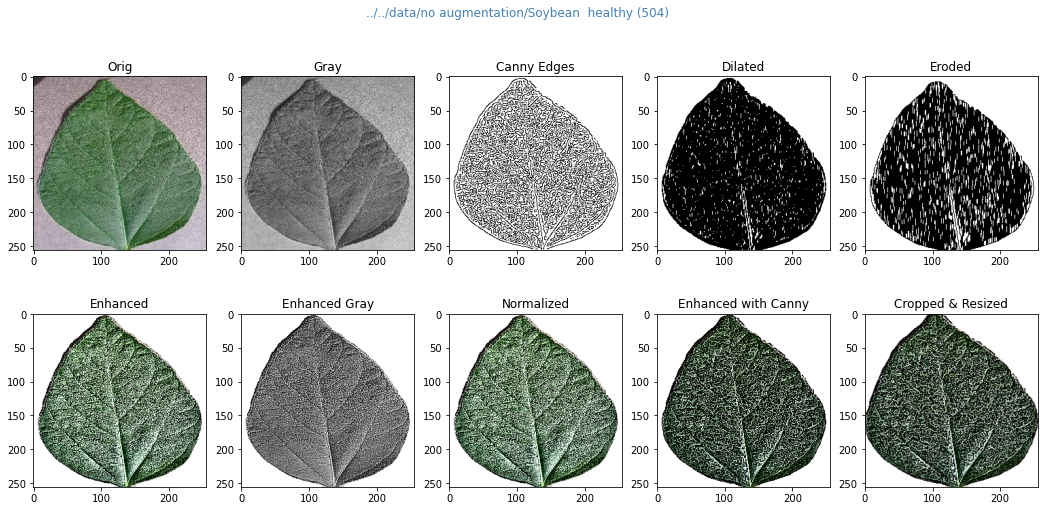

In [14]:
pyplot_display_images(WP_specie.value, WP_healthy.value, WP_DisFami.value, WP_Disease.value)